In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler  # Added WeightedRandomSampler
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import Adam
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd


In [1]:
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
def create_dataset_split(base_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Create train/validation/test splits"""
    assert train_ratio + val_ratio + test_ratio == 1.0
    
    base_path = Path(base_path)
    train_dir = Path('train')
    val_dir = Path('val')
    test_dir = Path('test')
    
    # Create directories
    for dir_path in [train_dir, val_dir, test_dir]:
        if dir_path.exists():
            shutil.rmtree(dir_path)
        
        for class_name in ['brain_glioma', 'brain_menin']:
            (dir_path / class_name).mkdir(parents=True, exist_ok=True)
    
    # Split and copy files
    for class_name in ['brain_glioma', 'brain_menin']:
        # Get all images
        class_path = base_path / class_name
        images = list(class_path.glob('*.jpg'))
        total_images = len(images)
        
        # Calculate split sizes
        train_size = int(total_images * train_ratio)
        val_size = int(total_images * val_ratio)
        test_size = total_images - train_size - val_size
        
        # Randomly shuffle images
        np.random.shuffle(images)
        
        # Split images
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]
        
        # Copy files to respective directories
        for img_path in train_images:
            shutil.copy2(str(img_path), str(train_dir / class_name / img_path.name))
        for img_path in val_images:
            shutil.copy2(str(img_path), str(val_dir / class_name / img_path.name))
        for img_path in test_images:
            shutil.copy2(str(img_path), str(test_dir / class_name / img_path.name))
            
        print(f"{class_name}:")
        print(f"Total: {total_images}")
        print(f"Train: {len(train_images)} ({len(train_images)/total_images:.1%})")
        print(f"Val: {len(val_images)} ({len(val_images)/total_images:.1%})")
        print(f"Test: {len(test_images)} ({len(test_images)/total_images:.1%})\n")

# Create the splits
create_dataset_split('dataset')

brain_glioma:
Total: 1000
Train: 700 (70.0%)
Val: 150 (15.0%)
Test: 150 (15.0%)

brain_menin:
Total: 47
Train: 32 (68.1%)
Val: 7 (14.9%)
Test: 8 (17.0%)



Dataset Summary:
Total number of images: 732

Class Distribution:


,Class,Number of Images,Percentage,Image Size
0,brain_glioma,700,100.000000,512x512
1,brain_menin,32,4.371585,512x512


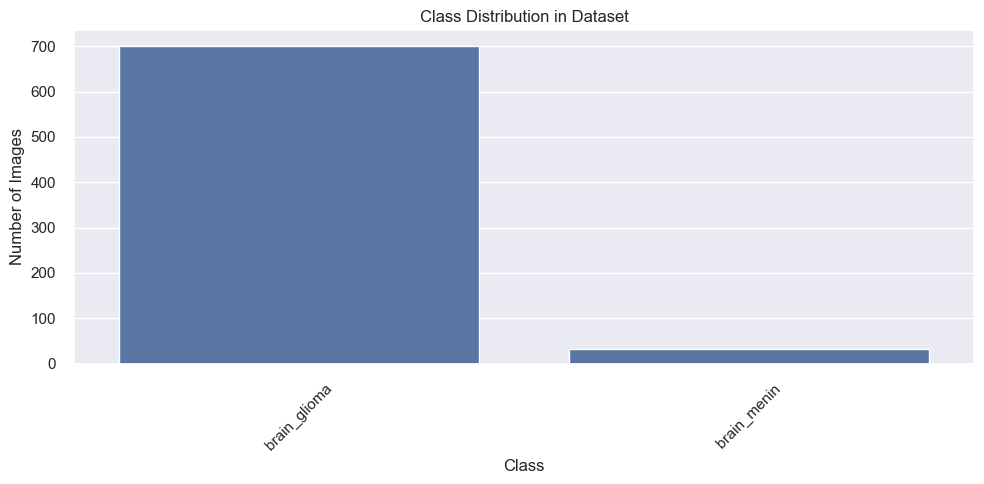

In [3]:
def explore_dataset(base_path='train'):
    """Explore and analyze the dataset"""
    train_path = Path(base_path)
    
    # Collect dataset statistics
    stats = []
    total_images = 0
    
    for class_dir in ['brain_glioma', 'brain_menin']:
        class_path = train_path / class_dir
        if not class_path.exists():
            print(f"Warning: {class_path} not found")
            continue
            
        # Get all images
        images = list(class_path.glob('*.jpg'))
        num_images = len(images)
        total_images += num_images
        
        # Sample image for size analysis
        if images:
            sample_img = Image.open(images[0])
            img_size = sample_img.size
        else:
            img_size = (0, 0)
            
        stats.append({
            'Class': class_dir,
            'Number of Images': num_images,
            'Percentage': num_images * 100 / total_images if total_images > 0 else 0,
            'Image Size': f"{img_size[0]}x{img_size[1]}"
        })
    
    # Create DataFrame
    df = pd.DataFrame(stats)
    
    # Print statistics
    print("Dataset Summary:")
    print(f"Total number of images: {total_images}")
    print("\nClass Distribution:")
    display(df)
    
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='Class', y='Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df

# Explore the dataset
dataset_stats = explore_dataset()

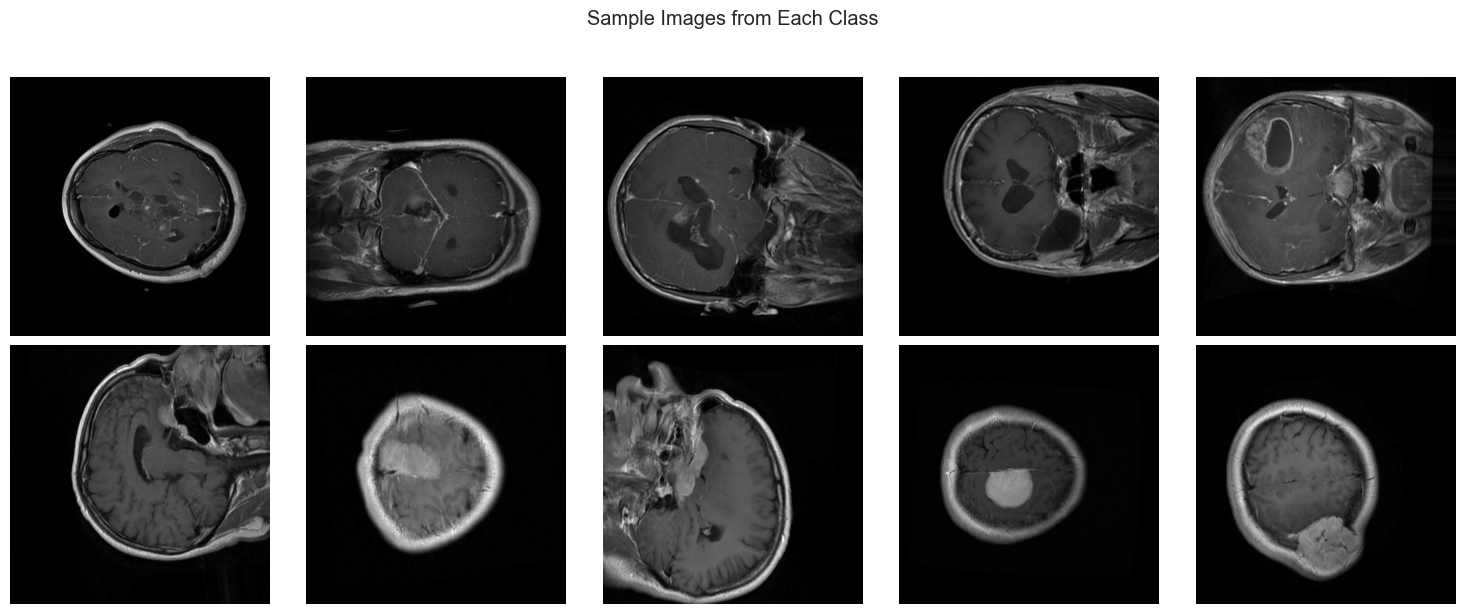

In [4]:
def show_sample_images(base_path='train', samples_per_class=5):
    """Display sample images from each class"""
    classes = ['brain_glioma', 'brain_menin']
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 6))
    
    for i, class_name in enumerate(classes):
        class_path = Path(base_path) / class_name
        images = list(class_path.glob('*.jpg'))
        
        if len(images) >= samples_per_class:
            samples = np.random.choice(images, samples_per_class, replace=False)
            
            for j, img_path in enumerate(samples):
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                if j == 0:
                    axes[i, j].set_ylabel(class_name.replace('brain_', ''))
    
    plt.suptitle('Sample Images from Each Class', y=1.02)
    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images()

In [5]:

# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(root='train', transform=train_transform)
val_dataset = ImageFolder(root='val', transform=val_transform)
test_dataset = ImageFolder(root='test', transform=val_transform)

# Calculate weights for balanced sampling
def calculate_class_weights(dataset):
    """Calculate weights for balanced sampling"""
    # Get all labels
    labels = [label for _, label in dataset.samples]
    
    # Count samples per class
    class_counts = np.bincount(labels)
    
    # Calculate weights
    total_samples = len(labels)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    
    # Assign weight to each sample
    sample_weights = [class_weights[label] for label in labels]
    
    return WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(sample_weights),
        replacement=True
    )

# Create data loaders with balanced sampling
train_sampler = calculate_class_weights(train_dataset)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler,
    num_workers=2,
    pin_memory=True  # Added for faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Print dataset information
print("\nDataset sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Print class distribution
labels = [label for _, label in train_dataset.samples]
class_counts = np.bincount(labels)
print("\nClass distribution in training set:")
for idx, count in enumerate(class_counts):
    print(f"Class {train_dataset.classes[idx]}: {count} samples")


Dataset sizes:
Training samples: 732
Validation samples: 157
Test samples: 158

Class distribution in training set:
Class brain_glioma: 700 samples
Class brain_menin: 32 samples


In [6]:
class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False
            
        # Modify final layers
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss, and optimizer
model = ResNetClassifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train_model():
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total
        
        # Store history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'resnet_classifier.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

# Train the model
histories = train_model()

Epoch 1/20:
Train Loss: 0.3277, Train Acc: 0.8634
Val Loss: 0.4142, Val Acc: 0.8790
Epoch 2/20:
Train Loss: 0.1187, Train Acc: 0.9563
Val Loss: 0.1114, Val Acc: 0.9682
Epoch 3/20:
Train Loss: 0.0830, Train Acc: 0.9672
Val Loss: 0.0677, Val Acc: 0.9745
Epoch 4/20:
Train Loss: 0.0386, Train Acc: 0.9877
Val Loss: 0.1317, Val Acc: 0.9618
Epoch 5/20:
Train Loss: 0.0575, Train Acc: 0.9795
Val Loss: 0.0867, Val Acc: 0.9809
Epoch 6/20:
Train Loss: 0.0484, Train Acc: 0.9891
Val Loss: 0.0893, Val Acc: 0.9682
Epoch 7/20:
Train Loss: 0.0324, Train Acc: 0.9891
Val Loss: 0.1175, Val Acc: 0.9682
Epoch 8/20:
Train Loss: 0.0363, Train Acc: 0.9918
Val Loss: 0.0512, Val Acc: 0.9809
Epoch 9/20:
Train Loss: 0.0265, Train Acc: 0.9891
Val Loss: 0.1152, Val Acc: 0.9682
Epoch 10/20:
Train Loss: 0.0506, Train Acc: 0.9863
Val Loss: 0.0464, Val Acc: 0.9809
Epoch 11/20:
Train Loss: 0.0258, Train Acc: 0.9904
Val Loss: 0.1238, Val Acc: 0.9745
Epoch 12/20:
Train Loss: 0.0289, Train Acc: 0.9877
Val Loss: 0.1019, Val A

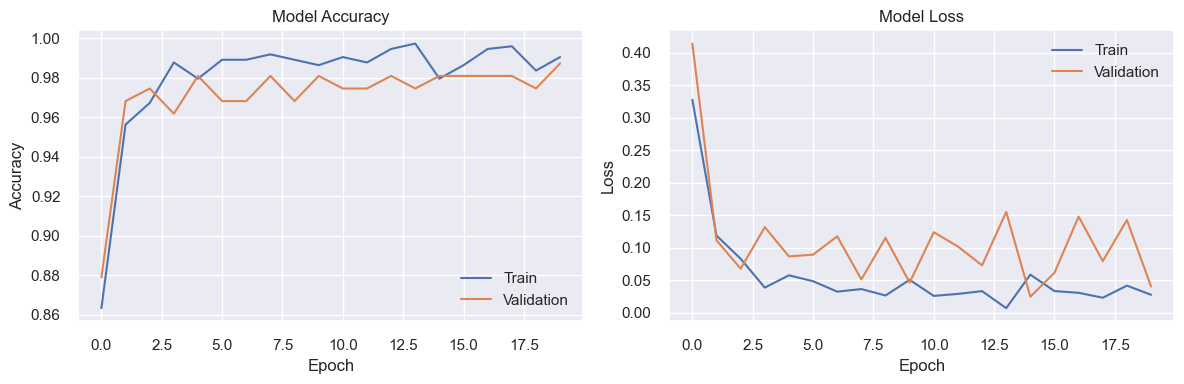

Test Loss: 0.0424, Test Acc: 0.9810


In [8]:
# Plot training history
train_acc, val_acc, train_loss, val_loss = histories

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model():
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Run evaluation
evaluate_model()


In [9]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.models as models

class DenseNetClassifier(nn.Module):
    def __init__(self):
        super(DenseNetClassifier, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        
        # Freeze early layers
        for param in list(self.densenet.parameters())[:-50]:
            param.requires_grad = False
            
        # Modify final layers
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.densenet(x)


In [10]:

# Initialize model
model = DenseNetClassifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
patience = 7
patience_counter = 0

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predictions = (outputs > 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = train_correct / train_total
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total
    
    # Store history
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)
    
    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
    
    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'densenet_classifier.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20:
Train Loss: 0.5797, Train Acc: 0.7131
Val Loss: 0.3335, Val Acc: 0.9299
Epoch 2/20:
Train Loss: 0.2655, Train Acc: 0.8962
Val Loss: 0.1292, Val Acc: 0.9682
Epoch 3/20:
Train Loss: 0.1380, Train Acc: 0.9481
Val Loss: 0.1221, Val Acc: 0.9682
Epoch 4/20:
Train Loss: 0.1184, Train Acc: 0.9454
Val Loss: 0.1287, Val Acc: 0.9682
Epoch 5/20:
Train Loss: 0.0667, Train Acc: 0.9768
Val Loss: 0.1326, Val Acc: 0.9682
Epoch 6/20:
Train Loss: 0.0709, Train Acc: 0.9768
Val Loss: 0.1344, Val Acc: 0.9682
Epoch 7/20:
Train Loss: 0.0352, Train Acc: 0.9932
Val Loss: 0.1192, Val Acc: 0.9745
Epoch 8/20:
Train Loss: 0.0570, Train Acc: 0.9809
Val Loss: 0.1255, Val Acc: 0.9809
Epoch 9/20:
Train Loss: 0.0345, Train Acc: 0.9877
Val Loss: 0.1220, Val Acc: 0.9745
Epoch 10/20:
Train Loss: 0.0533, Train Acc: 0.9863
Val Loss: 0.1265, Val Acc: 0.9745
Epoch 11/20:
Train Loss: 0.0322, Train Acc: 0.9932
Val Loss: 0.1064, Val Acc: 0.9682
Epoch 12/20:
Train Loss: 0.0259, Train Acc: 0.9918
Val Loss: 0.1221, Val A

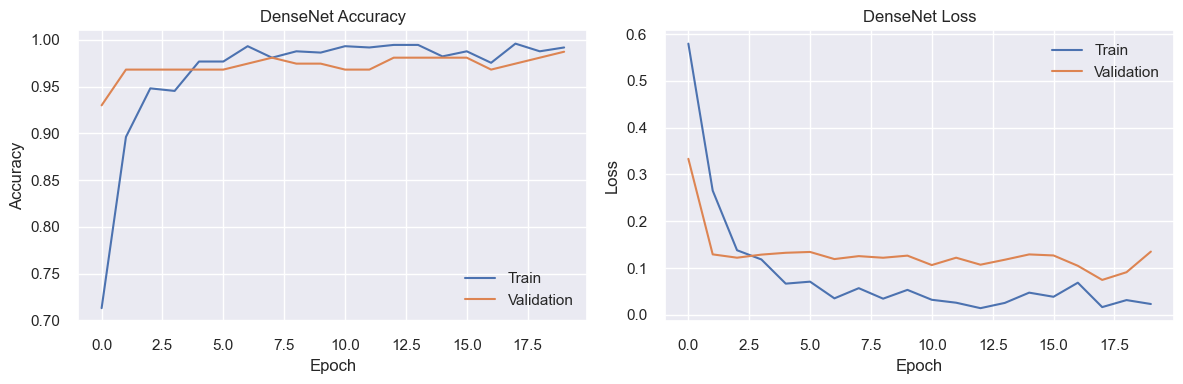

Test Loss: 0.0238, Test Acc: 0.9937


In [11]:

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train')
plt.plot(val_acc_history, label='Validation')
plt.title('DenseNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('DenseNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model():
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Run evaluation
evaluate_model()

C:\Users\Salah_Radwan\AppData\Local\Temp\ipykernel_32544\3660657124.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet_clas

ResNet Test Results:
Test Loss: 0.0824, Test Acc: 0.9620
DenseNet Test Results:
Test Loss: 0.0443, Test Acc: 0.9873


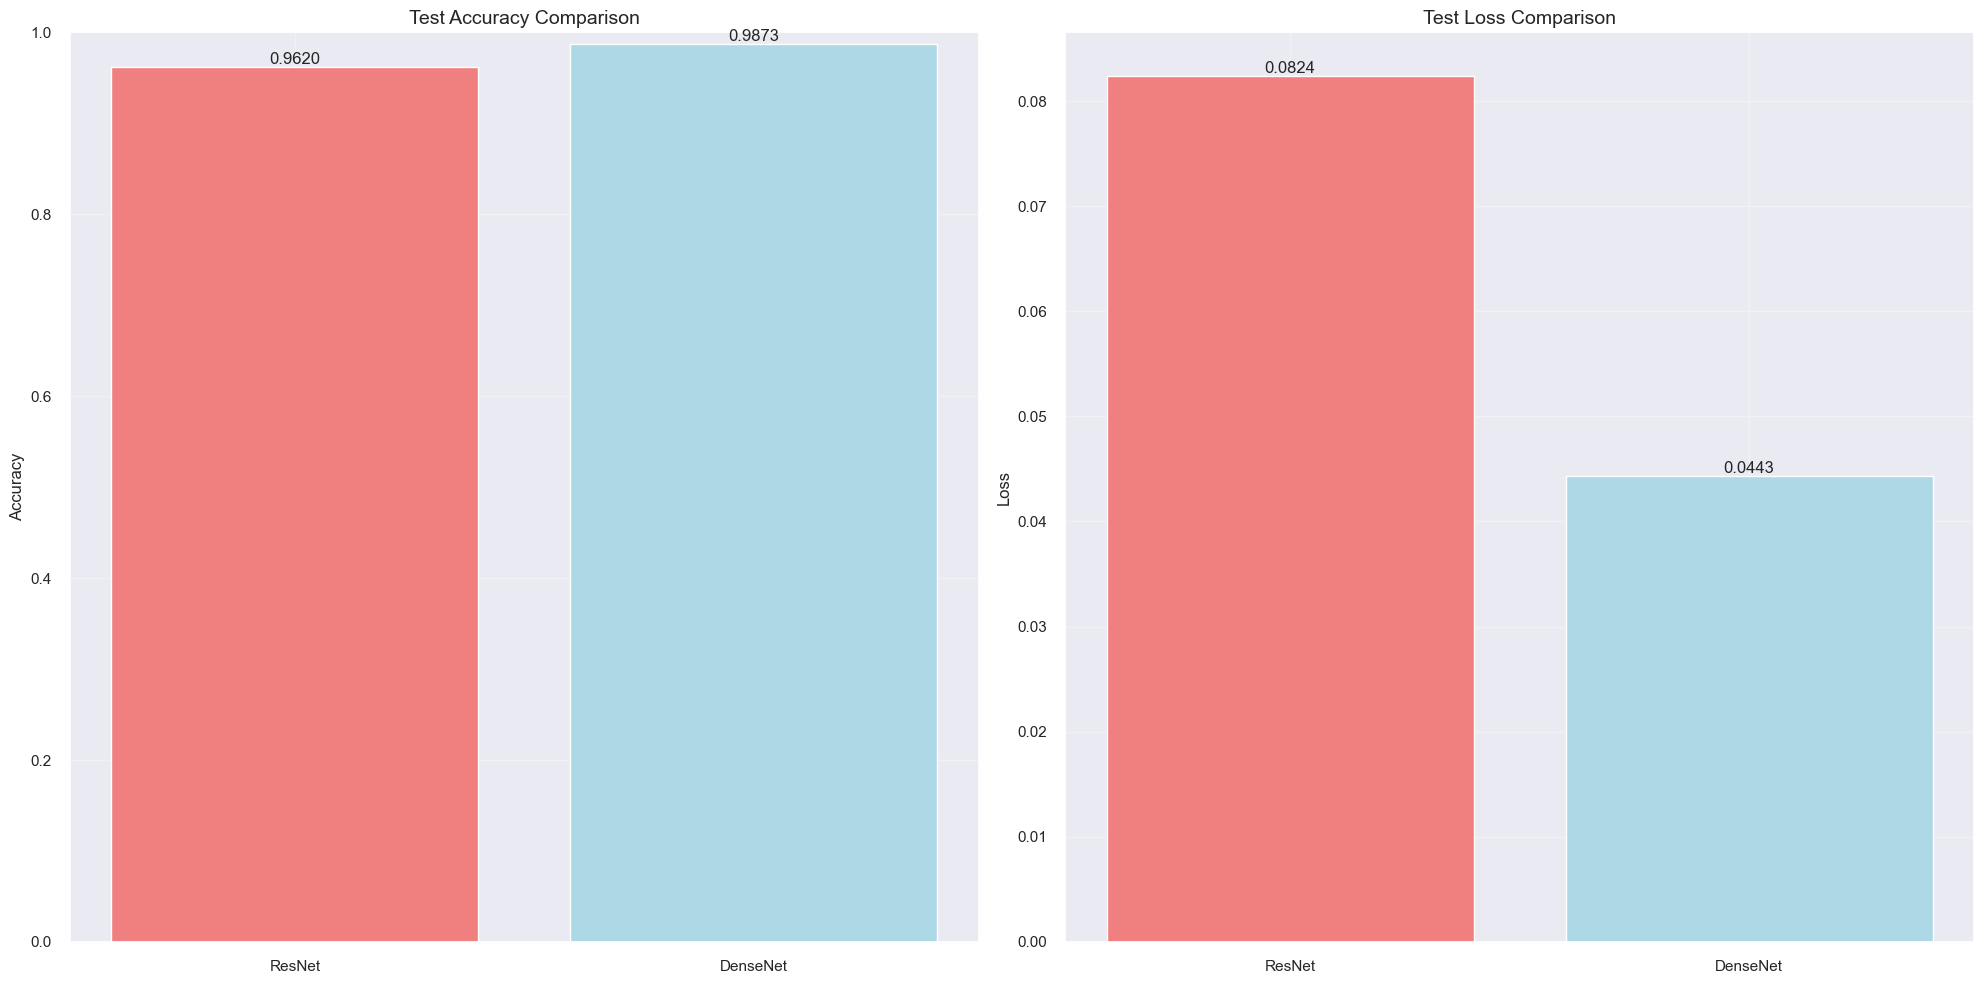


Model Performance Comparison
Model      Test Accuracy   Test Loss 
--------------------------------------------------
ResNet     0.9620         0.0824
DenseNet   0.9873         0.0443

Performance Analysis:
Accuracy Improvement: +2.63%
Loss Improvement: +46.24%

Better performing model: DenseNet

Detailed Metrics:
------------------------------
Accuracy Difference: 0.0253
Loss Difference: 0.0381


In [12]:
def evaluate_model(model_name, model, test_loader):
    """Evaluate model performance on test set"""
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    print(f'{model_name} Test Results:')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc

# Load and evaluate both models
resnet_model = ResNetClassifier().to(DEVICE)
resnet_model.load_state_dict(torch.load('resnet_classifier.pth'))

densenet_model = DenseNetClassifier().to(DEVICE)
densenet_model.load_state_dict(torch.load('densenet_classifier.pth'))

# Get test results for both models
resnet_test_loss, resnet_test_acc = evaluate_model('ResNet', resnet_model, test_loader)
densenet_test_loss, densenet_test_acc = evaluate_model('DenseNet', densenet_model, test_loader)

# Create comparison plots
plt.figure(figsize=(20, 10))

# Test Accuracy Bar Plot
plt.subplot(1, 2, 1)
models = ['ResNet', 'DenseNet']
test_accuracies = [resnet_test_acc, densenet_test_acc]
bars = plt.bar(models, test_accuracies, color=['lightcoral', 'lightblue'])
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# Test Loss Bar Plot
plt.subplot(1, 2, 2)
test_losses = [resnet_test_loss, densenet_test_loss]
bars = plt.bar(models, test_losses, color=['lightcoral', 'lightblue'])
plt.title('Test Loss Comparison', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nModel Performance Comparison")
print("=" * 50)
print(f"{'Model':<10} {'Test Accuracy':<15} {'Test Loss':<10}")
print("-" * 50)
print(f"ResNet     {resnet_test_acc:.4f}         {resnet_test_loss:.4f}")
print(f"DenseNet   {densenet_test_acc:.4f}         {densenet_test_loss:.4f}")
print("=" * 50)

# Calculate and print improvements
acc_improvement = ((densenet_test_acc - resnet_test_acc) / resnet_test_acc) * 100
loss_improvement = ((resnet_test_loss - densenet_test_loss) / resnet_test_loss) * 100

print("\nPerformance Analysis:")
print(f"Accuracy Improvement: {acc_improvement:+.2f}%")
print(f"Loss Improvement: {loss_improvement:+.2f}%")

# Determine better model
better_model = "DenseNet" if densenet_test_acc > resnet_test_acc else "ResNet"
print(f"\nBetter performing model: {better_model}")

# Additional metrics
print("\nDetailed Metrics:")
print("-" * 30)
print(f"Accuracy Difference: {abs(densenet_test_acc - resnet_test_acc):.4f}")
print(f"Loss Difference: {abs(densenet_test_loss - resnet_test_loss):.4f}")

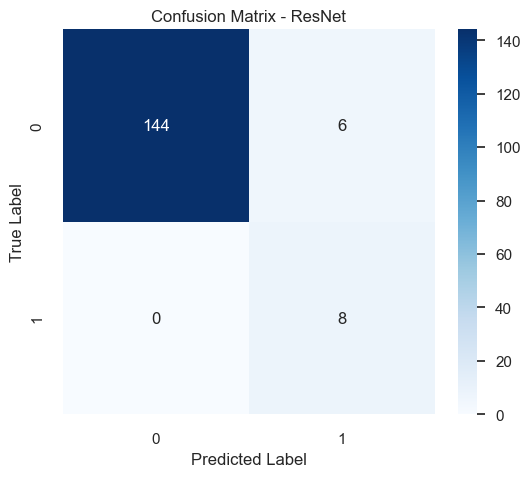

ResNet Test Results:
Test Loss: 0.0824, Test Acc: 0.9620


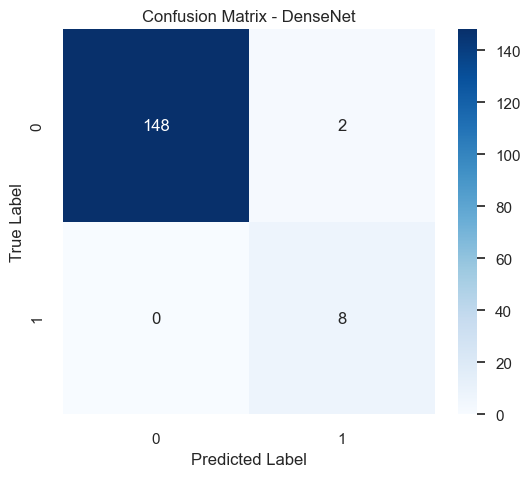

DenseNet Test Results:
Test Loss: 0.0443, Test Acc: 0.9873


In [19]:
def plot_confusion_matrix(model, model_name, test_loader):
    """Plot confusion matrix for a model"""
    model.eval()
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    
    criterion = nn.BCELoss()
    test_loss = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    
    # Calculate accuracy the same way as original evaluation
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"{model_name} Test Results:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Plot confusion matrices for both models
plot_confusion_matrix(resnet_model, "ResNet", test_loader)
plot_confusion_matrix(densenet_model, "DenseNet", test_loader)